# 실습 과제 1. Lab 3 CNN MNIST 실습에서 Dropout 을 추가하기 전과 후의 모델을 각각 학습시키고 결과를 논의하세요.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit

In [9]:


# Step 1: Define the transformations and load the MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

# Same stratified split setup
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = trainset.targets
for train_index, val_index in sss.split(np.zeros(len(targets)), targets):
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)


trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 38109953.92it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 935215.78it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 10571363.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19127036.92it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## dropout 추가하기 전

Epoch 1 - Training Loss: 0.148, Accuracy: 95.48%, Validation Loss: 0.063, Accuracy: 98.20%
Epoch 2 - Training Loss: 0.041, Accuracy: 98.68%, Validation Loss: 0.054, Accuracy: 98.45%
Epoch 3 - Training Loss: 0.027, Accuracy: 99.11%, Validation Loss: 0.048, Accuracy: 98.73%
Epoch 4 - Training Loss: 0.018, Accuracy: 99.44%, Validation Loss: 0.057, Accuracy: 98.42%
Epoch 5 - Training Loss: 0.013, Accuracy: 99.55%, Validation Loss: 0.051, Accuracy: 98.77%
Epoch 6 - Training Loss: 0.009, Accuracy: 99.68%, Validation Loss: 0.063, Accuracy: 98.67%
Epoch 7 - Training Loss: 0.011, Accuracy: 99.61%, Validation Loss: 0.056, Accuracy: 98.75%
Epoch 8 - Training Loss: 0.007, Accuracy: 99.77%, Validation Loss: 0.058, Accuracy: 98.95%
Epoch 9 - Training Loss: 0.004, Accuracy: 99.86%, Validation Loss: 0.070, Accuracy: 98.68%
Epoch 10 - Training Loss: 0.005, Accuracy: 99.82%, Validation Loss: 0.066, Accuracy: 98.85%
Finished Training
Accuracy of the network on the 10,000 test images: 98.98%


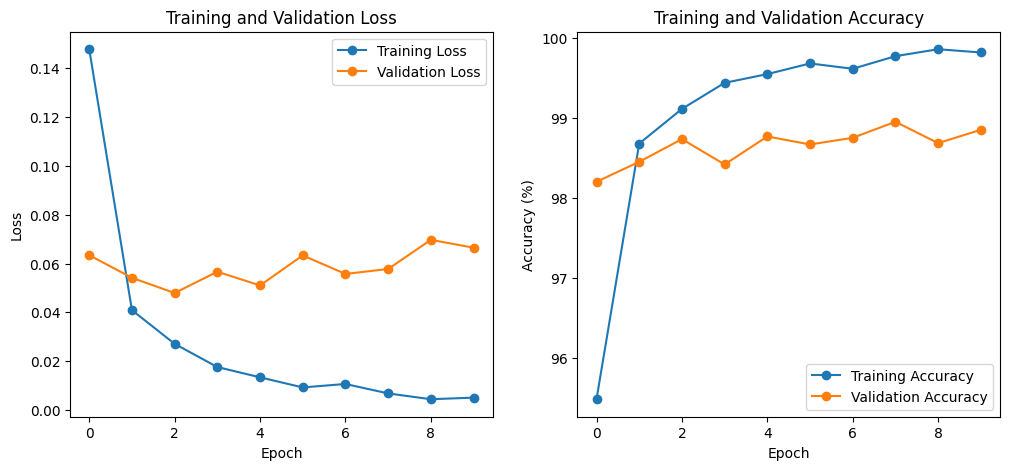

In [ ]:
# Step 2: Define the CNN architecture
class NoDropoutNet(nn.Module):
    def __init__(self):
        super(NoDropoutNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nodropoutnet = NoDropoutNet().to(device)

# Step 3: Define a Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nodropoutnet.parameters(), lr=0.001)

# Step 5: Train the network and validate every epoch
train_losses_1_1 = []
train_accuracy_1_1 = []
val_losses_1_1 = []
val_accuracy_1_1 = []


for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    nodropoutnet.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = nodropoutnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses_1_1.append(running_loss / len(trainloader))
    train_accuracy_1_1.append(100 * correct / total)

    # Validation step
    nodropoutnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = nodropoutnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses_1_1.append(val_loss / len(valloader))
    val_accuracy_1_1.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses_1_1[-1]:.3f}, Accuracy: {train_accuracy_1_1[-1]:.2f}%, Validation Loss: {val_losses_1_1[-1]:.3f}, Accuracy: {val_accuracy_1_1[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
nodropoutnet.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = nodropoutnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_1_1, '-o',label='Training Loss')
plt.plot(val_losses_1_1, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_1_1,  '-o',label='Training Accuracy')
plt.plot(val_accuracy_1_1, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
import pandas as pd
df11 = pd.DataFrame({'nodropout_train_loss':train_losses_1_1,'nodropout_train_acc' :train_accuracy_1_1,
                     'nodropout_val_loss':val_losses_1_1,'nodropout_val_acc' :val_accuracy_1_1})
df11.to_csv('/content/drive/MyDrive/숙명여대수업/전자공_딥러닝수업/df11.csv')

In [ ]:
# Step 5: Test the network on the test data
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = nodropoutnet(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * test_correct / test_total}%')

Accuracy of the network on the 10,000 test images: 98.98%


## dropout 추가한 후

In [ ]:
# Step 2: Define the CNN architecture
class DropoutNet(nn.Module):
    def __init__(self):
        super(DropoutNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(6400, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dropoutnet = DropoutNet().to(device)

# Step 3: Define a Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dropoutnet.parameters(), lr=0.001)

# Step 5: Train the network and validate every epoch
train_losses_1_2 = []
train_accuracy_1_2 = []
val_losses_1_2 = []
val_accuracy_1_2 = []

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    dropoutnet.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = dropoutnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses_1_2.append(running_loss / len(trainloader))
    train_accuracy_1_2.append(100 * correct / total)

    # Validation step
    dropoutnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = dropoutnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses_1_2.append(val_loss / len(valloader))
    val_accuracy_1_2.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses_1_2[-1]:.3f}, Accuracy: {train_accuracy_1_2[-1]:.2f}%, Validation Loss: {val_losses_1_2[-1]:.3f}, Accuracy: {val_accuracy_1_2[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
dropoutnet.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = dropoutnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_1_2, '-o',label='Training Loss')
plt.plot(val_losses_1_2, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_1_2,  '-o',label='Training Accuracy')
plt.plot(val_accuracy_1_2, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

torch.Size([64, 64, 10, 10])


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


#### 모델 조금 더 복잡

Epoch 1 - Training Loss: 0.179, Accuracy: 94.45%, Validation Loss: 0.052, Accuracy: 98.37%
Epoch 2 - Training Loss: 0.063, Accuracy: 98.10%, Validation Loss: 0.047, Accuracy: 98.63%
Epoch 3 - Training Loss: 0.046, Accuracy: 98.56%, Validation Loss: 0.041, Accuracy: 98.78%
Epoch 4 - Training Loss: 0.036, Accuracy: 98.85%, Validation Loss: 0.040, Accuracy: 98.80%
Epoch 5 - Training Loss: 0.031, Accuracy: 99.01%, Validation Loss: 0.042, Accuracy: 98.72%
Epoch 6 - Training Loss: 0.027, Accuracy: 99.19%, Validation Loss: 0.050, Accuracy: 98.70%
Epoch 7 - Training Loss: 0.022, Accuracy: 99.26%, Validation Loss: 0.053, Accuracy: 98.78%
Epoch 8 - Training Loss: 0.021, Accuracy: 99.32%, Validation Loss: 0.045, Accuracy: 98.75%
Epoch 9 - Training Loss: 0.018, Accuracy: 99.45%, Validation Loss: 0.054, Accuracy: 98.77%
Epoch 10 - Training Loss: 0.016, Accuracy: 99.51%, Validation Loss: 0.045, Accuracy: 98.75%
Finished Training
Accuracy of the network on the 10,000 test images: 99.10%


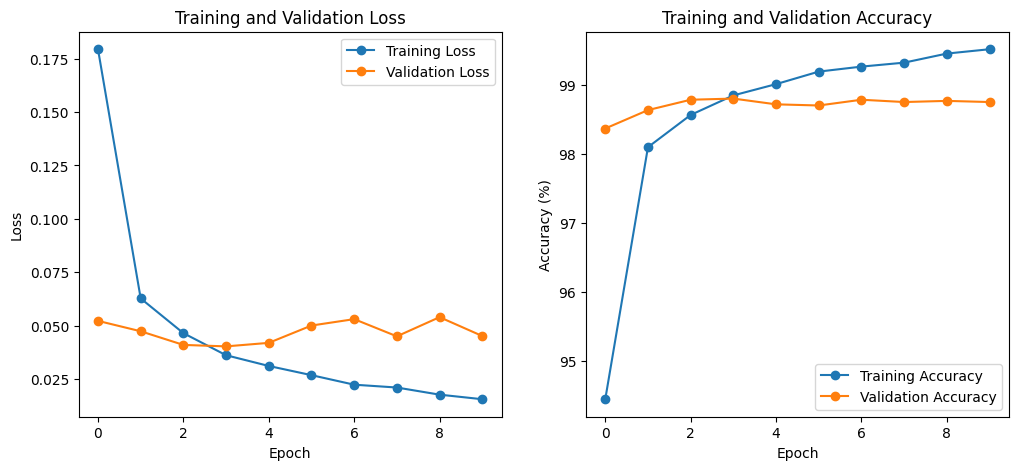

In [21]:
# Step 2: Define the CNN architecture
class DropoutNet(nn.Module):
    def __init__(self):
        super(DropoutNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(6400, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.conv4(x)
        x = nn.functional.relu(x)

        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dropoutnet = DropoutNet().to(device)

# Step 3: Define a Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dropoutnet.parameters(), lr=0.001)

# Step 5: Train the network and validate every epoch
train_losses_1_2 = []
train_accuracy_1_2 = []
val_losses_1_2 = []
val_accuracy_1_2 = []

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    dropoutnet.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = dropoutnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses_1_2.append(running_loss / len(trainloader))
    train_accuracy_1_2.append(100 * correct / total)

    # Validation step
    dropoutnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = dropoutnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses_1_2.append(val_loss / len(valloader))
    val_accuracy_1_2.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses_1_2[-1]:.3f}, Accuracy: {train_accuracy_1_2[-1]:.2f}%, Validation Loss: {val_losses_1_2[-1]:.3f}, Accuracy: {val_accuracy_1_2[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
dropoutnet.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = dropoutnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_1_2, '-o',label='Training Loss')
plt.plot(val_losses_1_2, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_1_2,  '-o',label='Training Accuracy')
plt.plot(val_accuracy_1_2, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# 실습 과제 2. Lab 3 CNN MNIST 실습에서 데이터셋을 CIFAR10으로 바꾸고 GlobalAverage Pooling를 추가하기 전과 후 모델을 각각 수정하여 약 1M 개의 파라미터로 학습시키고 비교하여 결과를 논의하세요.

In [2]:
# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize for 3 channels

cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cirfat10_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


# Same stratified split setup
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = cifar10_trainset.targets
for train_index, val_index in sss.split(np.zeros(len(targets)), targets):
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)


cifat10_trainloader = DataLoader(cifar10_trainset, batch_size=64, sampler=train_sampler)
cifat10_valloader = DataLoader(cifar10_trainset, batch_size=64, sampler=val_sampler)
cifat10_testloader = DataLoader(cirfat10_testset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:17<00:00, 9659106.26it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## GlobalAverage Pooling 추가하기 전

## batch_norm : O , GlobalAverage Pooling : X

Epoch 1 - Training Loss: 1.169, Accuracy: 57.86%, Validation Loss: 0.870, Accuracy: 68.76%
Epoch 2 - Training Loss: 0.735, Accuracy: 74.17%, Validation Loss: 0.777, Accuracy: 72.42%
Epoch 3 - Training Loss: 0.590, Accuracy: 79.25%, Validation Loss: 0.620, Accuracy: 77.88%
Epoch 4 - Training Loss: 0.479, Accuracy: 83.11%, Validation Loss: 0.603, Accuracy: 79.38%
Epoch 5 - Training Loss: 0.398, Accuracy: 86.08%, Validation Loss: 0.550, Accuracy: 80.80%
Epoch 6 - Training Loss: 0.327, Accuracy: 88.64%, Validation Loss: 0.561, Accuracy: 81.90%
Epoch 7 - Training Loss: 0.265, Accuracy: 90.75%, Validation Loss: 0.528, Accuracy: 83.08%
Epoch 8 - Training Loss: 0.210, Accuracy: 92.68%, Validation Loss: 0.632, Accuracy: 81.16%
Epoch 9 - Training Loss: 0.169, Accuracy: 94.07%, Validation Loss: 0.601, Accuracy: 82.64%
Epoch 10 - Training Loss: 0.133, Accuracy: 95.28%, Validation Loss: 0.666, Accuracy: 81.80%
Finished Training
Accuracy of the network on the 10,000 test images: 81.16%


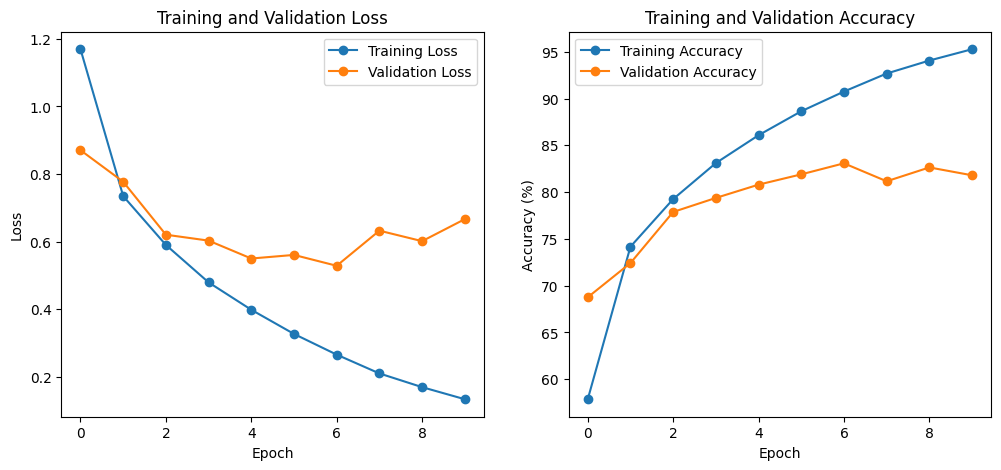

In [3]:
# Step 2: Adjust the CNN architecture to handle 3 channel input
class NoglobalaverageNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)    # Changed from 1 to 3 to handle RGB channels
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) #
        self.bn4 = nn.BatchNorm2d(256) #
        self.conv5 = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1) #
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = x.view(-1, 4096)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
noglonet = NoglobalaverageNet().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(noglonet.parameters(), lr=0.001)

# Step 5: Train the network
train_losses_2_1 = []
train_accuracy_2_1 = []
val_losses_2_1 = []
val_accuracy_2_1 = []


for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    noglonet.train()
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = noglonet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses_2_1.append(running_loss / len(cifat10_trainloader))
    train_accuracy_2_1.append(100 * correct / total)

    # Validation step
    noglonet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in cifat10_valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = noglonet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses_2_1.append(val_loss / len(cifat10_valloader))
    val_accuracy_2_1.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses_2_1[-1]:.3f}, Accuracy: {train_accuracy_2_1[-1]:.2f}%, Validation Loss: {val_losses_2_1[-1]:.3f}, Accuracy: {val_accuracy_2_1[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
noglonet.eval()
with torch.no_grad():
    for data in cifat10_testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = noglonet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_2_1, '-o',label='Training Loss')
plt.plot(val_losses_2_1, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_2_1,  '-o',label='Training Accuracy')
plt.plot(val_accuracy_2_1, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [5]:
noglonet = NoglobalaverageNet().to(device)
total_params = sum(p.numel() for p in noglonet.parameters())
print(f"Total Parameters: {total_params/1000}k")

Total Parameters: 1119.178k


In [ ]:
import pandas as pd
df21 = pd.DataFrame({'noglo_train_loss':train_losses_2_1,'noglo_train_acc' :train_accuracy_2_1,
                     'noglo_val_loss':val_losses_2_1,'noglo_val_acc' :val_accuracy_2_1})
df21.to_csv('/content/drive/MyDrive/숙명여대수업/전자공_딥러닝수업/df21.csv')

## GlobalAverage Pooling 추가한 후

## batch_norm : O , GlobalAverage Pooling : O

Epoch 1 - Training Loss: 1.713, Accuracy: 34.45%, Validation Loss: 1.397, Accuracy: 47.34%
Epoch 2 - Training Loss: 1.283, Accuracy: 52.92%, Validation Loss: 1.213, Accuracy: 56.34%
Epoch 3 - Training Loss: 1.090, Accuracy: 60.55%, Validation Loss: 0.998, Accuracy: 63.56%
Epoch 4 - Training Loss: 0.951, Accuracy: 65.59%, Validation Loss: 0.868, Accuracy: 68.30%
Epoch 5 - Training Loss: 0.848, Accuracy: 69.69%, Validation Loss: 0.859, Accuracy: 69.42%
Epoch 6 - Training Loss: 0.759, Accuracy: 73.02%, Validation Loss: 0.792, Accuracy: 71.66%
Epoch 7 - Training Loss: 0.683, Accuracy: 75.80%, Validation Loss: 0.708, Accuracy: 74.88%
Epoch 8 - Training Loss: 0.620, Accuracy: 78.11%, Validation Loss: 0.716, Accuracy: 75.24%
Epoch 9 - Training Loss: 0.561, Accuracy: 80.09%, Validation Loss: 0.733, Accuracy: 75.52%
Epoch 10 - Training Loss: 0.494, Accuracy: 82.71%, Validation Loss: 0.649, Accuracy: 77.92%
Finished Training
Accuracy of the network on the 10,000 test images: 78.24%


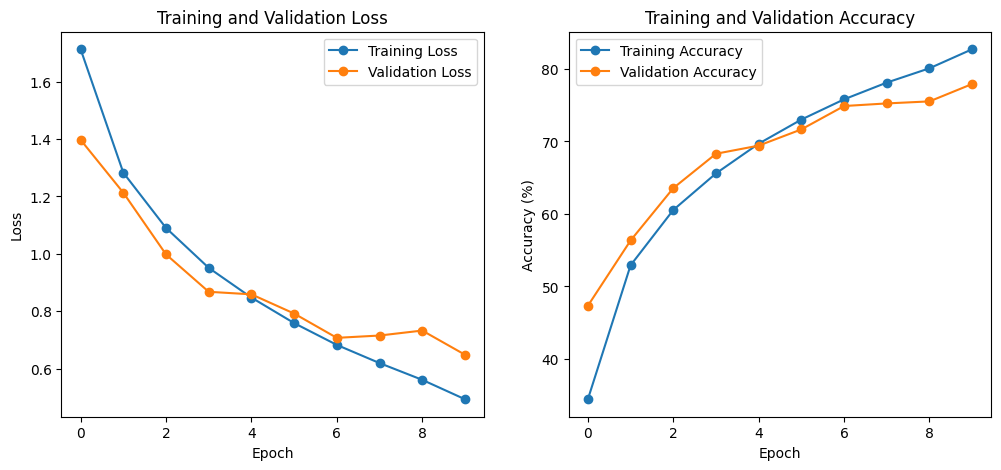

In [ ]:
# Step 2: Adjust the CNN architecture to handle 3 channel input
class GlobalaverageNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  # Changed from 1 to 3 to handle RGB channels
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
glonet = GlobalaverageNet().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(glonet.parameters(), lr=0.001)

# Step 5: Train the network and validate every epoch
train_losses_2_2 = []
train_accuracy_2_2 = []
val_losses_2_2 = []
val_accuracy_2_2 = []

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    glonet.train()
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = glonet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses_2_2.append(running_loss / len(cifat10_trainloader))
    train_accuracy_2_2.append(100 * correct / total)

    # Validation step
    glonet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in cifat10_valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = glonet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses_2_2.append(val_loss / len(cifat10_valloader))
    val_accuracy_2_2.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses_2_2[-1]:.3f}, Accuracy: {train_accuracy_2_2[-1]:.2f}%, Validation Loss: {val_losses_2_2[-1]:.3f}, Accuracy: {val_accuracy_2_2[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
glonet.eval()
with torch.no_grad():
    for data in cifat10_testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = glonet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_2_2, '-o',label='Training Loss')
plt.plot(val_losses_2_2, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_2_2,  '-o',label='Training Accuracy')
plt.plot(val_accuracy_2_2, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [7]:
# prompt: count the total number of learnable parameters

total_params = sum(p.numel() for p in glonet.parameters())
print(f"Total Parameters: {total_params/1000} k")


Total Parameters: 1072.138 k


#### 모델을 좀 더 복잡하게

Epoch 1 - Training Loss: 1.597, Accuracy: 39.76%, Validation Loss: 1.540, Accuracy: 46.62%
Epoch 2 - Training Loss: 1.111, Accuracy: 60.02%, Validation Loss: 1.206, Accuracy: 57.06%
Epoch 3 - Training Loss: 0.908, Accuracy: 67.38%, Validation Loss: 1.026, Accuracy: 64.44%
Epoch 4 - Training Loss: 0.764, Accuracy: 72.93%, Validation Loss: 0.837, Accuracy: 71.66%
Epoch 5 - Training Loss: 0.644, Accuracy: 77.53%, Validation Loss: 0.730, Accuracy: 75.02%
Epoch 6 - Training Loss: 0.556, Accuracy: 80.54%, Validation Loss: 0.644, Accuracy: 78.56%
Epoch 7 - Training Loss: 0.464, Accuracy: 83.91%, Validation Loss: 0.575, Accuracy: 80.64%
Epoch 8 - Training Loss: 0.397, Accuracy: 86.19%, Validation Loss: 0.611, Accuracy: 79.50%
Epoch 9 - Training Loss: 0.338, Accuracy: 88.28%, Validation Loss: 0.615, Accuracy: 79.64%
Epoch 10 - Training Loss: 0.274, Accuracy: 90.34%, Validation Loss: 0.674, Accuracy: 79.56%
Finished Training
Accuracy of the network on the 10,000 test images: 78.36%


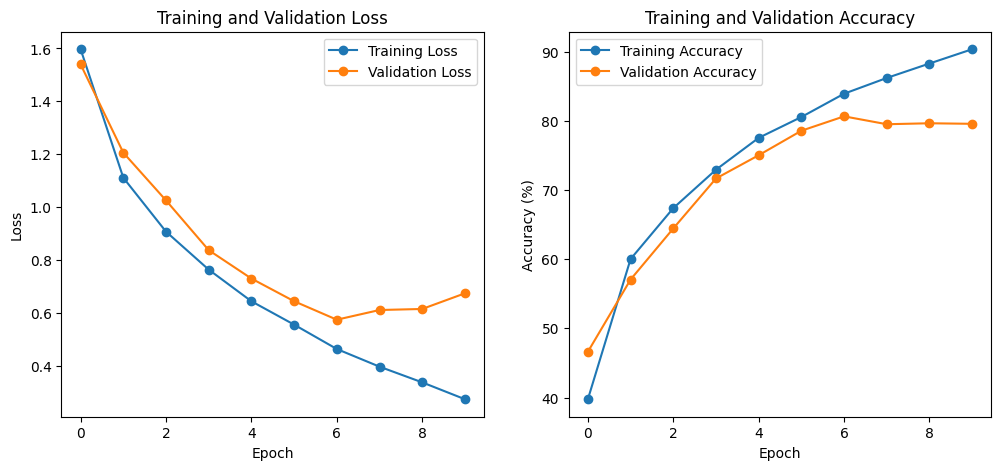

In [22]:
# Step 2: Adjust the CNN architecture to handle 3 channel input
class GlobalaverageNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  # Changed from 1 to 3 to handle RGB channels
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
glonet = GlobalaverageNet().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(glonet.parameters(), lr=0.01)

# Step 5: Train the network and validate every epoch
train_losses_2_2 = []
train_accuracy_2_2 = []
val_losses_2_2 = []
val_accuracy_2_2 = []

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    glonet.train()
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = glonet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses_2_2.append(running_loss / len(cifat10_trainloader))
    train_accuracy_2_2.append(100 * correct / total)

    # Validation step
    glonet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in cifat10_valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = glonet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses_2_2.append(val_loss / len(cifat10_valloader))
    val_accuracy_2_2.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses_2_2[-1]:.3f}, Accuracy: {train_accuracy_2_2[-1]:.2f}%, Validation Loss: {val_losses_2_2[-1]:.3f}, Accuracy: {val_accuracy_2_2[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
glonet.eval()
with torch.no_grad():
    for data in cifat10_testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = glonet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_2_2, '-o',label='Training Loss')
plt.plot(val_losses_2_2, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_2_2,  '-o',label='Training Accuracy')
plt.plot(val_accuracy_2_2, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# 위 실습 과제 2, GAP를 추가한 모델에서 BatchNorm을 추가하기 전과 후를 각각 학습시키고 결과를 논의하세요.


## batchnorm 추가하기 전

## batch_norm : X , GlobalAverage Pooling : O

Epoch 1 - Training Loss: 1.712, Accuracy: 34.77%, Validation Loss: 1.345, Accuracy: 49.86%
Epoch 2 - Training Loss: 1.221, Accuracy: 55.59%, Validation Loss: 1.051, Accuracy: 61.72%
Epoch 3 - Training Loss: 1.025, Accuracy: 63.03%, Validation Loss: 0.949, Accuracy: 65.04%
Epoch 4 - Training Loss: 0.901, Accuracy: 67.68%, Validation Loss: 0.916, Accuracy: 67.76%
Epoch 5 - Training Loss: 0.806, Accuracy: 71.41%, Validation Loss: 0.851, Accuracy: 69.30%
Epoch 6 - Training Loss: 0.722, Accuracy: 74.28%, Validation Loss: 0.735, Accuracy: 74.30%
Epoch 7 - Training Loss: 0.655, Accuracy: 76.93%, Validation Loss: 0.683, Accuracy: 76.46%
Epoch 8 - Training Loss: 0.582, Accuracy: 79.46%, Validation Loss: 0.662, Accuracy: 77.64%
Epoch 9 - Training Loss: 0.528, Accuracy: 81.44%, Validation Loss: 0.655, Accuracy: 77.52%
Epoch 10 - Training Loss: 0.473, Accuracy: 83.33%, Validation Loss: 0.653, Accuracy: 78.18%
Finished Training
Accuracy of the network on the 10,000 test images: 77.95%


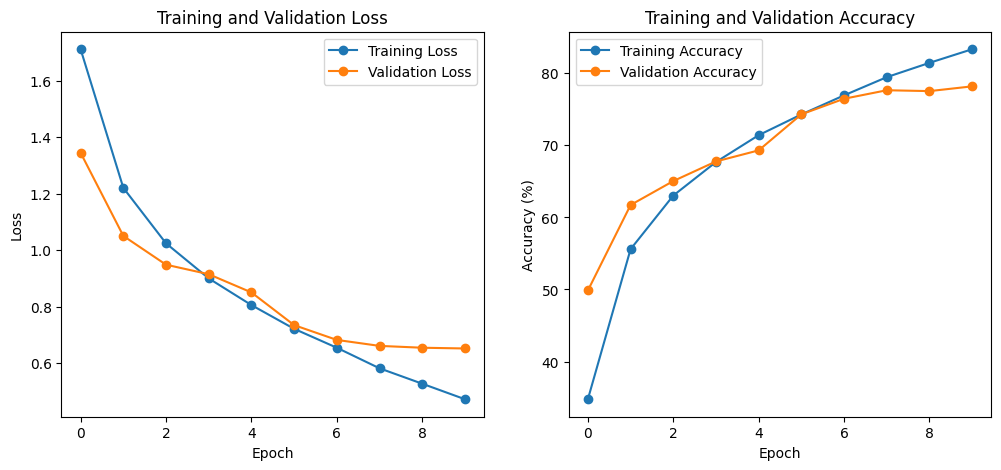

In [ ]:
# Step 2: Adjust the CNN architecture to handle 3 channel input
class NobatchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  # Changed from 1 to 3 to handle RGB channels
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nobatchnet = NobatchNet().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nobatchnet.parameters(), lr=0.001)

# Step 5: Train the network and validate every epoch
train_losses_3_1 = []
train_accuracy_3_1 = []
val_losses_3_1 = []
val_accuracy_3_1 = []


for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    nobatchnet.train()
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = nobatchnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses_3_1.append(running_loss / len(cifat10_trainloader))
    train_accuracy_3_1.append(100 * correct / total)

    # Validation step
    nobatchnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in cifat10_valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = nobatchnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses_3_1.append(val_loss / len(cifat10_valloader))
    val_accuracy_3_1.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses_3_1[-1]:.3f}, Accuracy: {train_accuracy_3_1[-1]:.2f}%, Validation Loss: {val_losses_3_1[-1]:.3f}, Accuracy: {val_accuracy_3_1[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
nobatchnet.eval()
with torch.no_grad():
    for data in cifat10_testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = nobatchnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_3_1, '-o',label='Training Loss')
plt.plot(val_losses_3_1, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_3_1,  '-o',label='Training Accuracy')
plt.plot(val_accuracy_3_1, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

#### learning rate 높게

Epoch 1 - Training Loss: 1.918, Accuracy: 25.22%, Validation Loss: 1.706, Accuracy: 33.46%
Epoch 2 - Training Loss: 1.626, Accuracy: 38.03%, Validation Loss: 1.550, Accuracy: 41.28%
Epoch 3 - Training Loss: 1.481, Accuracy: 44.84%, Validation Loss: 1.581, Accuracy: 42.12%
Epoch 4 - Training Loss: 1.393, Accuracy: 48.88%, Validation Loss: 1.341, Accuracy: 51.40%
Epoch 5 - Training Loss: 1.335, Accuracy: 51.30%, Validation Loss: 1.321, Accuracy: 51.52%
Epoch 6 - Training Loss: 1.293, Accuracy: 53.02%, Validation Loss: 1.281, Accuracy: 53.70%
Epoch 7 - Training Loss: 1.260, Accuracy: 54.38%, Validation Loss: 1.266, Accuracy: 54.34%
Epoch 8 - Training Loss: 1.231, Accuracy: 55.62%, Validation Loss: 1.278, Accuracy: 54.54%
Epoch 9 - Training Loss: 1.207, Accuracy: 56.44%, Validation Loss: 1.245, Accuracy: 55.62%
Epoch 10 - Training Loss: 1.186, Accuracy: 57.33%, Validation Loss: 1.204, Accuracy: 56.74%
Finished Training
Accuracy of the network on the 10,000 test images: 55.91%


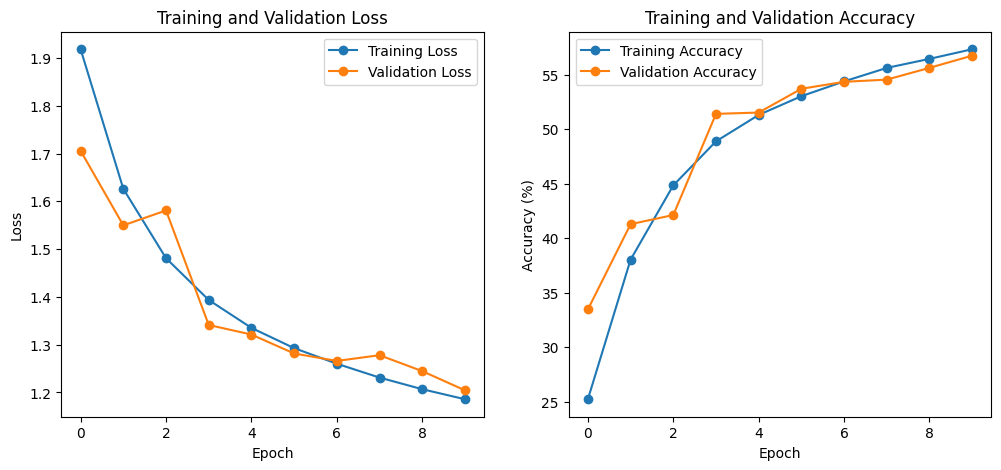

In [25]:
# Step 2: Adjust the CNN architecture to handle 3 channel input
class NobatchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  # Changed from 1 to 3 to handle RGB channels
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nobatchnet = NobatchNet().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nobatchnet.parameters(), lr=0.01)

# Step 5: Train the network and validate every epoch
train_losses_3_1 = []
train_accuracy_3_1 = []
val_losses_3_1 = []
val_accuracy_3_1 = []


for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    nobatchnet.train()
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = nobatchnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses_3_1.append(running_loss / len(cifat10_trainloader))
    train_accuracy_3_1.append(100 * correct / total)

    # Validation step
    nobatchnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in cifat10_valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = nobatchnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses_3_1.append(val_loss / len(cifat10_valloader))
    val_accuracy_3_1.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses_3_1[-1]:.3f}, Accuracy: {train_accuracy_3_1[-1]:.2f}%, Validation Loss: {val_losses_3_1[-1]:.3f}, Accuracy: {val_accuracy_3_1[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
nobatchnet.eval()
with torch.no_grad():
    for data in cifat10_testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = nobatchnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_3_1, '-o',label='Training Loss')
plt.plot(val_losses_3_1, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_3_1,  '-o',label='Training Accuracy')
plt.plot(val_accuracy_3_1, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
gradient_norms = []

for epoch in range(10):
    # 에포크별 그래디언트 노름을 저장할 변수
    epoch_gradient_norms = []
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = nobatchnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # 그래디언트 노름 계산
        total_norm = 0
        for p in nobatchnet.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        epoch_gradient_norms.append(total_norm)

        optimizer.step()

    # 에포크별 평균 그래디언트 노름을 기록합니다.
    gradient_norms.append(np.mean(epoch_gradient_norms))

for name, param in nobatchnet.named_parameters():
    if param.requires_grad:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.hist(param.data.cpu().numpy().flatten(), bins=100, alpha=0.7)
        plt.title(f'{name} weights')
        plt.subplot(1, 2, 2)
        plt.hist(param.grad.data.cpu().numpy().flatten(), bins=100, alpha=0.7)
        plt.title(f'{name} gradients')
        plt.show()

## batchnorm 추가한 후

## batch_norm : O , GlobalAverage Pooling : O

In [ ]:
# Step 2: Adjust the CNN architecture to handle 3 channel input
class BatchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  # Changed from 1 to 3 to handle RGB channels
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batchnet = BatchNet().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(batchnet.parameters(), lr=0.001)

# Step 5: Train the network and validate every epoch
train_losses_3_2 = []
train_accuracy_3_2 = []
val_losses_3_2 = []
val_accuracy_3_2 = []

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    batchnet.train()
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = batchnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses_3_2.append(running_loss / len(cifat10_trainloader))
    train_accuracy_3_2.append(100 * correct / total)

    # Validation step
    batchnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in cifat10_valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = batchnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses_3_2.append(val_loss / len(cifat10_valloader))
    val_accuracy_3_2.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses_3_2[-1]:.3f}, Accuracy: {train_accuracy_3_2[-1]:.2f}%, Validation Loss: {val_losses_3_2[-1]:.3f}, Accuracy: {val_accuracy_3_2[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
batchnet.eval()
with torch.no_grad():
    for data in cifat10_testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = batchnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_3_2, '-o',label='Training Loss')
plt.plot(val_losses_3_2, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_3_2,  '-o',label='Training Accuracy')
plt.plot(val_accuracy_3_2, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

#### learning rate 높게

In [ ]:
# Step 2: Adjust the CNN architecture to handle 3 channel input
class BatchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  # Changed from 1 to 3 to handle RGB channels
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batchnet = BatchNet().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(batchnet.parameters(), lr=0.01)

# Step 5: Train the network and validate every epoch
train_losses_3_2 = []
train_accuracy_3_2 = []
val_losses_3_2 = []
val_accuracy_3_2 = []

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    batchnet.train()
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = batchnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses_3_2.append(running_loss / len(cifat10_trainloader))
    train_accuracy_3_2.append(100 * correct / total)

    # Validation step
    batchnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in cifat10_valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = batchnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses_3_2.append(val_loss / len(cifat10_valloader))
    val_accuracy_3_2.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses_3_2[-1]:.3f}, Accuracy: {train_accuracy_3_2[-1]:.2f}%, Validation Loss: {val_losses_3_2[-1]:.3f}, Accuracy: {val_accuracy_3_2[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
batchnet.eval()
with torch.no_grad():
    for data in cifat10_testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = batchnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_3_2, '-o',label='Training Loss')
plt.plot(val_losses_3_2, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_3_2,  '-o',label='Training Accuracy')
plt.plot(val_accuracy_3_2, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
gradient_norms = []

for epoch in range(10):
    # 에포크별 그래디언트 노름을 저장할 변수
    epoch_gradient_norms = []
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = batchnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # 그래디언트 노름 계산
        total_norm = 0
        for p in batchnet.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        epoch_gradient_norms.append(total_norm)

        optimizer.step()

    # 에포크별 평균 그래디언트 노름을 기록합니다.
    gradient_norms.append(np.mean(epoch_gradient_norms))

for name, param in batchnet.named_parameters():
    if param.requires_grad:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.hist(param.data.cpu().numpy().flatten(), bins=100, alpha=0.7)
        plt.title(f'{name} weights')
        plt.subplot(1, 2, 2)
        plt.hist(param.grad.data.cpu().numpy().flatten(), bins=100, alpha=0.7)
        plt.title(f'{name} gradients')
        plt.show()

In [ ]:
df21= pd.read_csv('/content/drive/MyDrive/숙명여대수업/전자공_딥러닝수업/df21.csv',index_col=0)
df22= pd.read_csv('/content/drive/MyDrive/숙명여대수업/전자공_딥러닝수업/df22.csv',index_col=0)
df31= pd.read_csv('/content/drive/MyDrive/숙명여대수업/전자공_딥러닝수업/df31.csv',index_col=0)

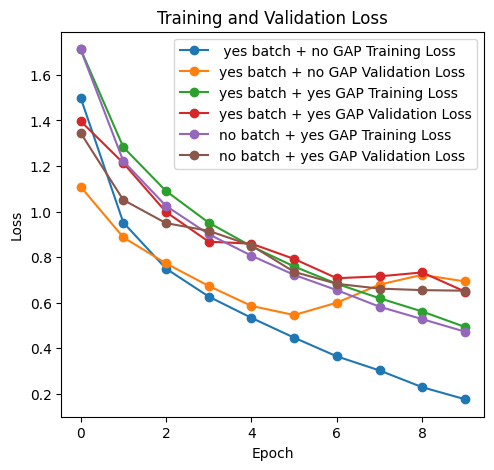

In [ ]:
# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df21.iloc[:,0], '-o',label=' yes batch + no GAP Training Loss')
plt.plot(df21.iloc[:,2], '-o', label='yes batch + no GAP Validation Loss')

plt.plot(df22.iloc[:,0], '-o',label='yes batch + yes GAP Training Loss')
plt.plot(df22.iloc[:,2], '-o', label='yes batch + yes GAP Validation Loss')

plt.plot(df31.iloc[:,0], '-o',label='no batch + yes GAP Training Loss')
plt.plot(df31.iloc[:,2], '-o', label='no batch + yes GAP Validation Loss')



plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

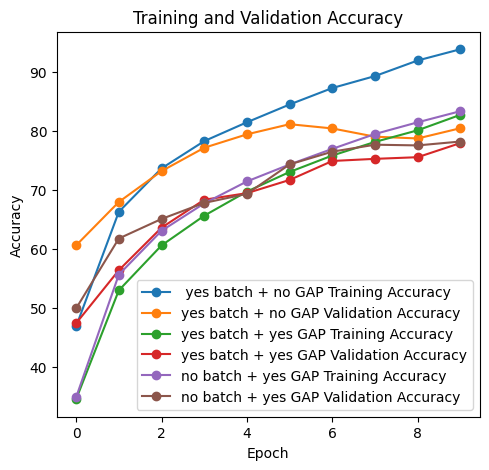

In [ ]:
# Step 7: Plot the learning curves for accuracy and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df21.iloc[:,1], '-o',label=' yes batch + no GAP Training Accuracy')
plt.plot(df21.iloc[:,3], '-o', label='yes batch + no GAP Validation Accuracy')

plt.plot(df22.iloc[:,1], '-o',label='yes batch + yes GAP Training Accuracy')
plt.plot(df22.iloc[:,3], '-o', label='yes batch + yes GAP Validation Accuracy')

plt.plot(df31.iloc[:,1], '-o',label='no batch + yes GAP Training Accuracy')
plt.plot(df31.iloc[:,3], '-o', label='no batch + yes GAP Validation Accuracy')



plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 실습 과제 4. Lab 3 Transfer Learning 실습에서 ResNet18의 (i) learnable parameters을 고정한 경우와 (ii) 마지막 3개 Layer만 제외하고 나머지 learnable parameters를 고정한 경우, (iii) 모든 레이어를 고정하지 않은 경우에 대해 학습시키고 결과를 논의하세요

## learnable parameters을 고정한 경우

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.0MB/s]


Epoch 1, Batch 200, Loss: 1.922, Accuracy: 32.54%
Epoch 1, Batch 400, Loss: 1.709, Accuracy: 40.05%
Epoch 1, Batch 600, Loss: 1.652, Accuracy: 42.27%
Epoch 1 - Training Loss: 1.744, Accuracy: 42.00%, Validation Loss: 1.644, Accuracy: 43.32%
Epoch 2, Batch 200, Loss: 1.619, Accuracy: 43.05%
Epoch 2, Batch 400, Loss: 1.611, Accuracy: 43.77%
Epoch 2, Batch 600, Loss: 1.606, Accuracy: 43.80%
Epoch 2 - Training Loss: 1.607, Accuracy: 44.92%, Validation Loss: 1.604, Accuracy: 45.48%
Epoch 3, Batch 200, Loss: 1.597, Accuracy: 43.91%
Epoch 3, Batch 400, Loss: 1.577, Accuracy: 45.38%
Epoch 3, Batch 600, Loss: 1.583, Accuracy: 44.48%
Epoch 3 - Training Loss: 1.583, Accuracy: 45.30%, Validation Loss: 1.597, Accuracy: 45.74%
Epoch 4, Batch 200, Loss: 1.575, Accuracy: 45.16%
Epoch 4, Batch 400, Loss: 1.556, Accuracy: 45.28%
Epoch 4, Batch 600, Loss: 1.581, Accuracy: 44.42%
Epoch 4 - Training Loss: 1.574, Accuracy: 45.21%, Validation Loss: 1.580, Accuracy: 45.72%
Epoch 5, Batch 200, Loss: 1.561, Acc

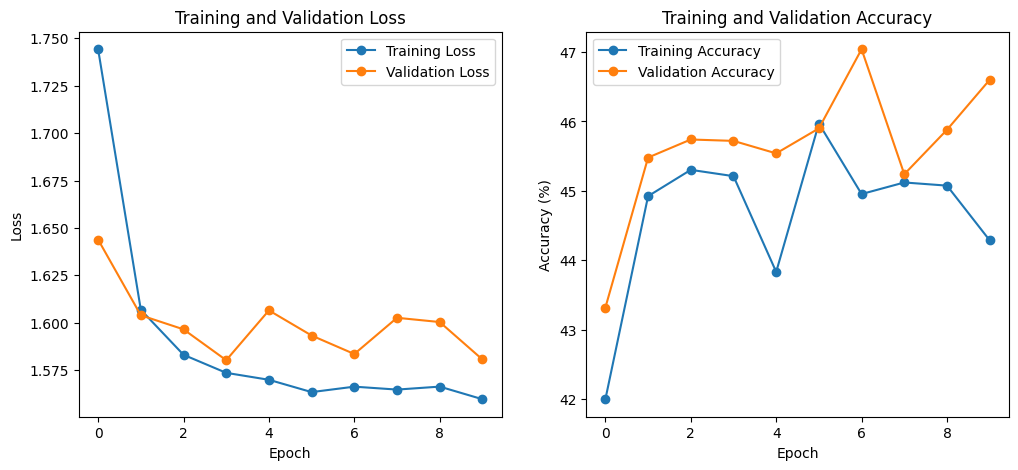

In [24]:
import torchvision.models as models

# Step 2: Define the CNN architecture with pretrained resnet18
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet and modify it
        self.resnet = models.resnet18(pretrained=True)

        # Freeze all the layers in the network
        for param in self.resnet.parameters():
            param.requires_grad = False

        # CIFAR-10 has 10 classes, modify the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)  # Adjust for 10 classes

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Step 5: Train the network and validate every epoch
train_losses = []
train_accuracy = []
train_losses_iter = []
train_accuracy_iter = []
val_losses = []
val_accuracy = []

for epoch in range(10):
    running_loss_iter = 0.0
    running_loss = 0.0
    correct = 0
    total = 0
    net.train()
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_iter += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:  # print and record every 200 mini-batches
            avg_loss = running_loss_iter / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses_iter.append(avg_loss)
            train_accuracy_iter.append(accuracy)
            running_loss_iter = 0.0
            correct = 0
            total = 0

    train_losses.append(running_loss / len(cifat10_trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation step
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in cifat10_valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(cifat10_valloader))
    val_accuracy.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy[-1]:.2f}%, Validation Loss: {val_losses[-1]:.3f}, Accuracy: {val_accuracy[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in cifat10_testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, '-o',label='Training Loss')
plt.plot(val_losses, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy,  '-o',label='Training Accuracy')
plt.plot(val_accuracy, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


## 마지막 3개 Layer만 제외하고 나머지 learnable parameters를 고정한 경우

Epoch 1, Batch 200, Loss: 1.354, Accuracy: 52.75%
Epoch 1, Batch 400, Loss: 1.110, Accuracy: 62.25%
Epoch 1, Batch 600, Loss: 1.032, Accuracy: 63.64%
Epoch 1 - Training Loss: 1.139, Accuracy: 65.44%, Validation Loss: 0.883, Accuracy: 69.28%
Epoch 2, Batch 200, Loss: 0.842, Accuracy: 70.68%
Epoch 2, Batch 400, Loss: 0.841, Accuracy: 70.96%
Epoch 2, Batch 600, Loss: 0.873, Accuracy: 69.75%
Epoch 2 - Training Loss: 0.854, Accuracy: 69.91%, Validation Loss: 0.867, Accuracy: 70.24%
Epoch 3, Batch 200, Loss: 0.701, Accuracy: 75.86%
Epoch 3, Batch 400, Loss: 0.725, Accuracy: 74.59%
Epoch 3, Batch 600, Loss: 0.732, Accuracy: 73.99%
Epoch 3 - Training Loss: 0.725, Accuracy: 73.29%, Validation Loss: 0.868, Accuracy: 70.50%
Epoch 4, Batch 200, Loss: 0.589, Accuracy: 79.41%
Epoch 4, Batch 400, Loss: 0.607, Accuracy: 78.77%
Epoch 4, Batch 600, Loss: 0.631, Accuracy: 77.58%
Epoch 4 - Training Loss: 0.619, Accuracy: 76.65%, Validation Loss: 0.908, Accuracy: 69.82%
Epoch 5, Batch 200, Loss: 0.517, Acc

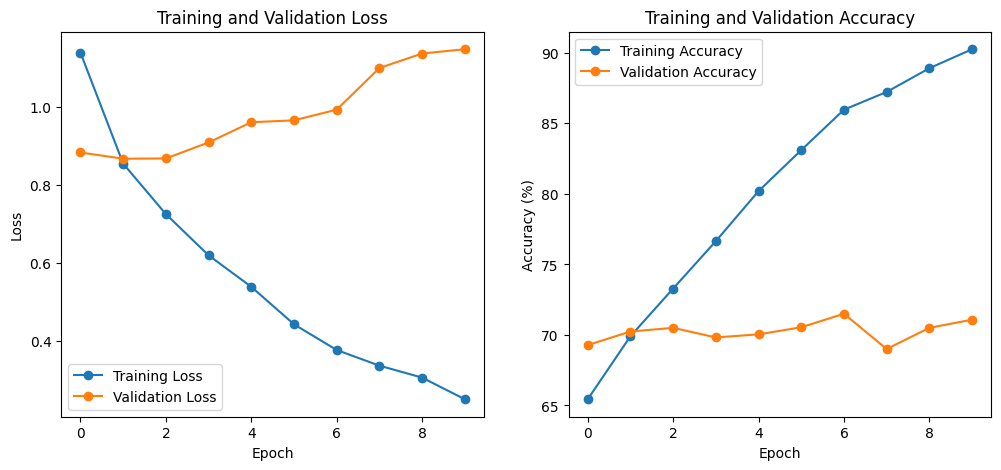

In [42]:
import torchvision.models as models

# Step 2: Define the CNN architecture with pretrained resnet
class Netlastthree(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)

        for param in self.resnet.parameters():
            param.requires_grad = False

        # layer4와 fc를 제외하고 모든 레이어를 학습에서 제외합니다.
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True
        for param in self.resnet.fc.parameters():
            param.requires_grad = True


        # CIFAR-10 클래스에 맞게 마지막 fully connected layer 수정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netlastthree = Netlastthree().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(netlastthree.parameters(), lr=0.001)

# Step 5: Train the netlastthreework and validate every epoch
train_losses = []
train_accuracy = []
train_losses_iter = []
train_accuracy_iter = []
val_losses = []
val_accuracy = []

for epoch in range(10):
    running_loss_iter = 0.0
    running_loss = 0.0
    correct = 0
    total = 0
    netlastthree.train()
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = netlastthree(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_iter += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:  # print and record every 200 mini-batches
            avg_loss = running_loss_iter / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses_iter.append(avg_loss)
            train_accuracy_iter.append(accuracy)
            running_loss_iter = 0.0
            correct = 0
            total = 0

    train_losses.append(running_loss / len(cifat10_trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation step
    netlastthree.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in cifat10_valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = netlastthree(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(cifat10_valloader))
    val_accuracy.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy[-1]:.2f}%, Validation Loss: {val_losses[-1]:.3f}, Accuracy: {val_accuracy[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the netlastthreework on the test data
correct = 0
total = 0
netlastthree.eval()
with torch.no_grad():
    for data in cifat10_testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = netlastthree(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the netlastthreework on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, '-o',label='Training Loss')
plt.plot(val_losses, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy,  '-o',label='Training Accuracy')
plt.plot(val_accuracy, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


## 모든 레이어를 고정하지 않은 경우

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 200, Loss: 1.241, Accuracy: 58.11%
Epoch 1, Batch 400, Loss: 0.925, Accuracy: 69.22%
Epoch 1, Batch 600, Loss: 0.838, Accuracy: 71.44%
Epoch 1 - Training Loss: 0.972, Accuracy: 73.62%, Validation Loss: 0.782, Accuracy: 73.38%
Epoch 2, Batch 200, Loss: 0.699, Accuracy: 76.81%
Epoch 2, Batch 400, Loss: 0.669, Accuracy: 77.79%
Epoch 2, Batch 600, Loss: 0.647, Accuracy: 77.99%
Epoch 2 - Training Loss: 0.669, Accuracy: 78.47%, Validation Loss: 0.696, Accuracy: 76.40%
Epoch 3, Batch 200, Loss: 0.527, Accuracy: 82.02%
Epoch 3, Batch 400, Loss: 0.532, Accuracy: 82.42%
Epoch 3, Batch 600, Loss: 0.523, Accuracy: 82.30%
Epoch 3 - Training Loss: 0.529, Accuracy: 82.67%, Validation Loss: 0.713, Accuracy: 75.88%
Epoch 4, Batch 200, Loss: 0.500, Accuracy: 83.16%
Epoch 4, Batch 400, Loss: 0.454, Accuracy: 84.74%
Epoch 4, Batch 600, Loss: 0.438, Accuracy: 85.36%
Epoch 4 - Training Loss: 0.461, Accuracy: 84.88%, Validation Loss: 0.598, Accuracy: 79.90%
Epoch 5, Batch 200, Loss: 0.304, Acc

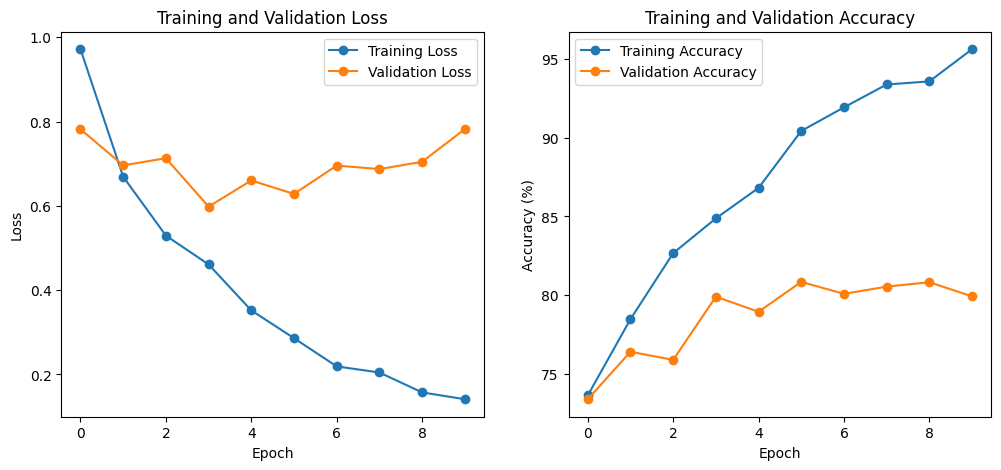

In [45]:
import torchvision.models as models

# Step 2: Define the CNN architecture with pretrained resnet
class NetAllTrainable(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)

        for param in self.resnet.parameters():
            param.requires_grad = True

        # CIFAR-10 클래스에 맞게 마지막 fully connected layer 수정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netlastthree = NetAllTrainable().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(netlastthree.parameters(), lr=0.001)

# Step 5: Train the netlastthreework and validate every epoch
train_losses = []
train_accuracy = []
train_losses_iter = []
train_accuracy_iter = []
val_losses = []
val_accuracy = []

for epoch in range(10):
    running_loss_iter = 0.0
    running_loss = 0.0
    correct = 0
    total = 0
    netlastthree.train()
    for i, data in enumerate(cifat10_trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = netlastthree(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_iter += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:  # print and record every 200 mini-batches
            avg_loss = running_loss_iter / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses_iter.append(avg_loss)
            train_accuracy_iter.append(accuracy)
            running_loss_iter = 0.0
            correct = 0
            total = 0

    train_losses.append(running_loss / len(cifat10_trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation step
    netlastthree.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in cifat10_valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = netlastthree(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(cifat10_valloader))
    val_accuracy.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy[-1]:.2f}%, Validation Loss: {val_losses[-1]:.3f}, Accuracy: {val_accuracy[-1]:.2f}%')

print('Finished Training')

# Step 6: Evaluate the netlastthreework on the test data
correct = 0
total = 0
netlastthree.eval()
with torch.no_grad():
    for data in cifat10_testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = netlastthree(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the netlastthreework on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, '-o',label='Training Loss')
plt.plot(val_losses, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy,  '-o',label='Training Accuracy')
plt.plot(val_accuracy, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()
